In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
torch.manual_seed(42)

In [12]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes


Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Define a simple neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

In [14]:
# Define the loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

In [15]:
# Train the model
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # Calculate test loss
    net.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(testloader))
    net.train()
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(trainloader)}, Test Loss: {test_loss / len(testloader)}')

Epoch 1/10, Training Loss: 1.4744453201293946, Test Loss: 1.3306878232955932
Epoch 2/10, Training Loss: 1.2392737264633178, Test Loss: 1.1775378441810609
Epoch 3/10, Training Loss: 1.1492526761293411, Test Loss: 1.097594901919365
Epoch 4/10, Training Loss: 1.0951754571199417, Test Loss: 1.063251468539238
Epoch 5/10, Training Loss: 1.0614378299713134, Test Loss: 1.0649371290206908
Epoch 6/10, Training Loss: 1.0373491804599762, Test Loss: 1.0462064498662949
Epoch 7/10, Training Loss: 1.0123960444927216, Test Loss: 1.0296349000930787
Epoch 8/10, Training Loss: 0.9937712390422822, Test Loss: 0.9923218590021133
Epoch 9/10, Training Loss: 0.9851094170808792, Test Loss: 0.9904349571466446
Epoch 10/10, Training Loss: 0.9764118169546128, Test Loss: 0.9827278381586075


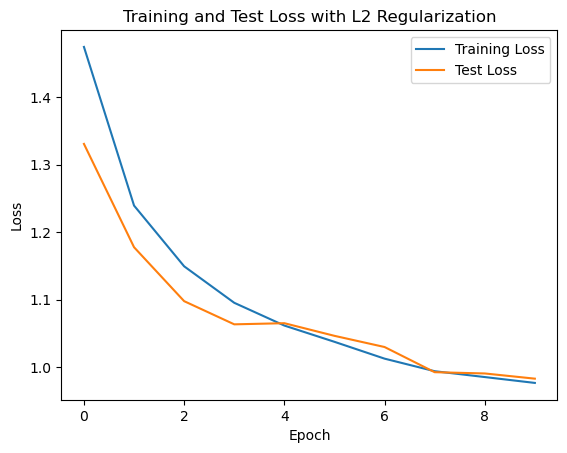

In [16]:
# Plot the training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss with L2 Regularization')
plt.show()